# Kalman Filter — 1D Position Tracker (Explanation)

This notebook contains a detailed derivation of the linear Kalman Filter for a 1D constant-velocity
system, a step-by-step implementation, simulation code, visualization, and suggestions for extensions.
All math is written with LaTeX (rendered by Jupyter).

## Contents

1. Model (State-space)
2. Process and measurement noise
3. Kalman filter derivation (predict & update)
4. Derivation of Kalman gain (matrix form)
5. Implementation (Python)
6. Experiments, tuning & visualization
7. Exporting results
8. Further reading and extensions


## 1. Model (State-space)

We model a 1D constant-velocity system with state vector

$$
x_k = \begin{bmatrix}
\text{position} \\
\text{velocity}
\end{bmatrix} \in \mathbb{R}^2
$$

Discrete-time dynamics with timestep $\Delta t$:

$$
x_{k+1} = A x_k + w_k, \qquad A = \begin{bmatrix}1 & \Delta t \\
0 & 1\end{bmatrix}
$$

Measurements provide position only:

$$
z_k = H x_k + v_k, \qquad H = \begin{bmatrix}1 & 0\end{bmatrix}
$$

The goal: estimate $x_k$ given noisy measurements $z_1,\dots,z_k$.

## 2. Process and measurement noise

We model process and measurement noise as zero-mean Gaussian:

$$
w_k \sim \mathcal{N}(0, Q), \qquad v_k \sim \mathcal{N}(0, R)
$$

For acceleration-driven process noise (unmodelled acceleration), the continuous-time influence can be discretized and approximated by choosing

$$
G = \begin{bmatrix}\tfrac{1}{2}\Delta t^2 \\\Delta t\end{bmatrix},
\qquad Q = \sigma_{\text{acc}}^2\, G G^\top.
$$

This yields a $2\times2$ positive semi-definite matrix $Q$ capturing how acceleration uncertainty affects position and velocity.

## 3. Kalman Filter — Predict & Update (matrix form)

**Predict step** (time update):

$$
\hat{x}_{k|k-1} = A\,\hat{x}_{k-1|k-1}
$$

$$
P_{k|k-1} = A P_{k-1|k-1} A^\top + Q
$$

**Update step** (measurement update):

Innovation (residual):
$$
y_k = z_k - H\,\hat{x}_{k|k-1}
$$
Innovation covariance:
$$
S_k = H P_{k|k-1} H^\top + R
$$
Kalman gain:
$$
K_k = P_{k|k-1} H^\top S_k^{-1}
$$
State update:
$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k y_k
$$
Covariance update:
$$
P_{k|k} = (I - K_k H) P_{k|k-1}
$$

These are the standard discrete-time linear Kalman filter equations.

## 4. Derivation of the Kalman gain

One way to derive the Kalman gain $K_k$ is by minimizing the trace (or equivalently, minimizing the posterior covariance) of the updated error covariance $P_{k|k}$ with respect to $K_k$.

Start with the update equation in general form:

$$\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H\hat{x}_{k|k-1}).$$

The posterior covariance (exact, before simplification) is:

$$P_{k|k} = (I - K_k H) P_{k|k-1} (I - K_k H)^\top + K_k R K_k^\top.$$ 

Differentiate the scalar objective $J = \text{tr}(P_{k|k})$ w.r.t. $K_k$ and set gradient to zero (matrix calculus). The solution yields:

$$K_k = P_{k|k-1} H^\top (H P_{k|k-1} H^\top + R)^{-1}.$$ 

This choice of $K_k$ minimizes the posterior covariance and yields the familiar Kalman gain formula.

Position RMSE: 0.2742


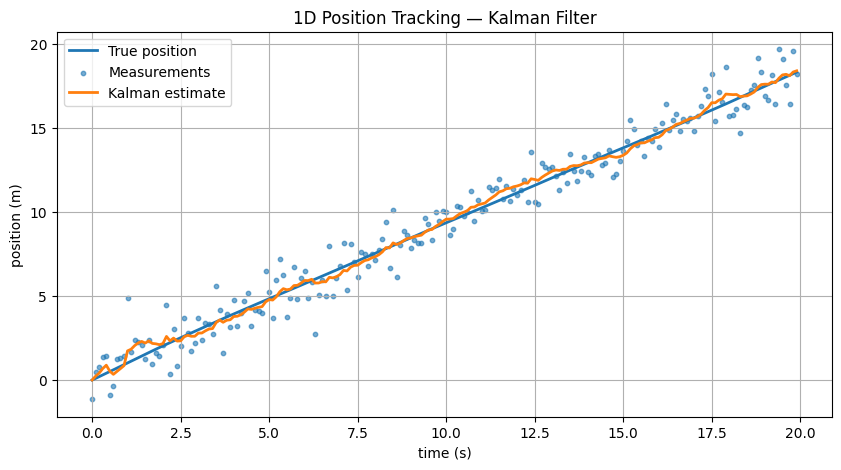

In [14]:

# Implementation: simulate a 1D constant-velocity system, generate measurements, run Kalman filter, and plot.
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -- simulation parameters --
dt = 0.1
T = 20.0
t = np.arange(0, T, dt)
n = t.size

# true motion: initial pos 0, initial vel 1.0 with slight acceleration pulses
x_true = np.zeros((2, n))
x_true[0,0] = 0.0
x_true[1,0] = 1.0

np.random.seed(42)
acc_noise_std = 0.5  # used to generate small process acceleration impulses (not filter Q)
for k in range(n-1):
    # small random acceleration
    a = 0.1 * np.random.randn()
    x_true[1,k+1] = x_true[1,k] + a*dt
    x_true[0,k+1] = x_true[0,k] + x_true[1,k]*dt + 0.5*a*dt*dt

# measurement noise
sigma_gps = 1.0
z = x_true[0,:] + sigma_gps * np.random.randn(n)

# filter matrices
A = np.array([[1.0, dt],[0.0, 1.0]])
H = np.array([[1.0, 0.0]])
G = np.array([[0.5*dt*dt],[dt]])
sigma_acc = 0.5
Q = (sigma_acc**2) * (G @ G.T)
R = np.array([[sigma_gps**2]])

# allocate
x_est = np.zeros((2, n))
P_est = np.zeros((2,2,n))
x_est[:,0] = np.array([0.0, 0.0])  # initial guess
P_est[:,:,0] = np.eye(2) * 1.0

# run kalman
for k in range(1,n):
    # predict
    x_pred = A @ x_est[:,k-1]
    P_pred = A @ P_est[:,:,k-1] @ A.T + Q

    # update
    y = z[k] - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + (K @ y).ravel()
    P_upd = (np.eye(2) - K @ H) @ P_pred

    # store
    x_est[:,k] = x_upd
    P_est[:,:,k] = P_upd

# compute RMSE for position
rmse_pos = np.sqrt(np.mean((x_est[0,:] - x_true[0,:])**2))
print(f"Position RMSE: {rmse_pos:.4f}")

# plotting
plt.figure(figsize=(10,5))
plt.plot(t, x_true[0,:], label='True position', linewidth=2)
plt.scatter(t, z, s=10, label='Measurements', alpha=0.6)
plt.plot(t, x_est[0,:], label='Kalman estimate', linewidth=2)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend()
plt.title('1D Position Tracking — Kalman Filter')
plt.grid(True)
plt.show()


## 6. Experiments, tuning & visualization

Try changing `sigma_gps` and `sigma_acc` in the simulation cell above to see how the filter responds.

- Increase `sigma_gps` to simulate a noisier sensor → estimate becomes smoother and more model-driven (lag increases).
- Increase `sigma_acc` to indicate more model uncertainty → Kalman gain increases, estimate follows measurements more closely.

You can also visualize covariance bands: the position variance is `P_est[0,0,k]`, so approximate 95% band is ±2·sqrt(P_est[0,0,k]).

In [15]:
import pandas as pd

# assemble DataFrame and save CSV
df = pd.DataFrame({
    't': t,
    'true_pos': x_true[0,:],
    'meas_pos': z,
    'est_pos': x_est[0,:],
    'true_vel': x_true[1,:],
    'est_vel': x_est[1,:]
})

# csv_path = 'kalman_simulation_results.csv'
# df.to_csv(csv_path, index=False)
# print(f'Saved CSV to {csv_path}')

## 7. Further reading and extensions

- Extended Kalman Filter (EKF) for nonlinear systems
- Unscented Kalman Filter (UKF) as an alternative to EKF
- Adaptive Kalman filters that estimate Q/R online
- Robust filters for heavy-tailed noise or outliers

References:
- Simon, D. (2006). Optimal State Estimation: Kalman, H∞, and Nonlinear Approaches.
- Maybeck, P. S. (1982). Stochastic Models, Estimation, and Control.